   Покупкой в данном проекте я посчитал оплаченный заказ, с любым статусом заказа кроме "отменен" и 'недоступен'. При отмене заказа деньги возвращаются обратно покупателю, а значит продажа не состоялась. При недоступном статусе видимо произошла какая-то ошибка на каком-либо из этапов формирвоания или отправки заказа, соответственно продажа также не состоялась, что подтверждается отсуствием информации о большинстве таких заказов в таблице 'olist_customers_datase' (информация по таким заказам есть лишь в 6 из 609 случаях).  
В таблице заказов есть разные статусы заказа, и если со статусами "отменен" и 'недоступен' я определился выше, а с "доставлено" всё и так ясно, то остальные статусы можно интерпретировать как:  
    1) заказ был принят, но его еще не успели отправить  
    2) заказ приняли, но товара не оказалось на складе/ожидается поступление  
    3) заказ приняли, отгрузили (статус 'shipped'), но от службы доставки не поступила информация о том, когда был доставлен товар, либо товар был утерян  
    4) при составлении таблицы заказов были допущены технические ошибки и статус заказа не был изменен на актуальный  
Но в любом случае продажа товара, а соответсвенно и покупка, состоялась, кроме случаев, где нет подтверждения платежа.

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np

In [21]:
olist_customers_datase = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/q1/olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/q1/olist_orders_dataset.csv', parse_dates=['order_estimated_delivery_date', 'order_approved_at'])
olist_order_items_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-bogdan-41/q1/olist_order_items_dataset.csv')

Задание 1

In [24]:
# Для удобства создадим новую таблицу включающую в себя все покупки, а также избавимся от данных с пропущенными значениями в графе "оплата"
purchases = olist_orders_dataset.query('order_status != ["unavailable", "canceled"]')
purchases = purchases.dropna(subset = ['order_approved_at'])

In [25]:
# найдем количество пользователей, совершивших лишь одну покупку за всё время
purchases.merge(olist_customers_datase, on = 'customer_id') \
.groupby('customer_unique_id', as_index = False).agg({'order_id': 'count'}) \
.groupby('order_id', as_index = False).agg({'customer_unique_id': 'count'}) \
.rename(columns = {'order_id': 'total_purchases', 'customer_unique_id': 'customers'})
# из полученной таблицы видно, что большинство пользователей совершило за всё время лишь одну покупку - таких 92087 клиента

,total_purchases,customers
0,1,92087
1,2,2650
2,3,188
3,4,29
4,5,9
5,6,5
6,7,3
7,9,1
8,16,1


Задание 2

In [26]:
# Создадим новую таблицу с недоставленными заказами
undelivered_orders = olist_orders_dataset.query('order_delivered_customer_date != order_delivered_customer_date')

In [27]:
# найдем количество месяцев между начальной и конечной датой предполагемой доставки товара
months = (undelivered_orders.order_estimated_delivery_date.max() - undelivered_orders.order_estimated_delivery_date.min()) / np.timedelta64 ( 1 , 'M')

In [28]:
# посчиатем по каким причинам не были доставлены товары
undelivered_orders = undelivered_orders.groupby('order_status').agg({'order_id': 'count'}) \
.rename(columns = {'order_id': 'num_orders'})

In [29]:
# удалим из таблицы лишние строки, которые по условию были признаны техническими ошибками, а также вычислим среднее значение недоставленных заказов в месяц
undelivered_orders['num_orders'] = undelivered_orders['num_orders'] / months
undelivered_orders = undelivered_orders.drop(['approved','created', 'delivered'],axis = 0)
undelivered_orders.num_orders.sum()
# получаем 116.15625 недоставленных заказов в среднем месяц

116.15625000000001

In [30]:
# сделаем разбивку по причинам
undelivered_orders = undelivered_orders.rename(index = {'canceled': 'отмененный заказ', 'invoiced': 'застрял на оформлении', 'processing': 'застрял на сборке', 'shipped': 'не доставлен службой доставки', 'unavailable': 'сбой по тех.причинам'}) \
.reset_index().rename(columns = {'order_status': 'причина не доставки', 'num_orders': 'недоставленных заказов в месяц'})
undelivered_orders


,причина не доставки,недоставленных заказов в месяц
0,отмененный заказ,24.373125
1,застрял на оформлении,12.363750
2,застрял на сборке,11.851875
3,не доставлен службой доставки,43.588125
4,сбой по тех.причинам,23.979375


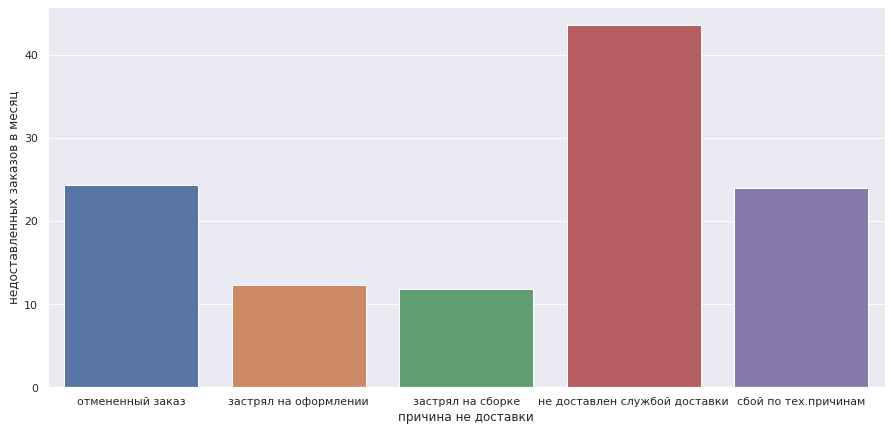

In [10]:
# построим график для наглдяности
sns.set(rc={"figure.figsize":( 15 , 7 )})
sns.barplot(x = undelivered_orders['причина не доставки'], y = undelivered_orders['недоставленных заказов в месяц']) 


Задание 3

In [31]:
# Создадим новую колонку с днем оплаты покупки. В этом задании будет использована копия таблицы из первого задания(таблица покупок)
purchases_day = purchases.copy()
purchases_day['day_of_purchase'] = purchases_day['order_approved_at'].dt.day_name()

In [32]:
# Объединим таблицу заказов с таблицей товаров, а также найдем наиболее популярные дни покупок для каждого товара
purchases_day.merge(olist_order_items_dataset, on = 'order_id') \
.groupby('product_id').agg({'day_of_purchase':pd.Series.mode})

,day_of_purchase
product_id,
00066f42aeeb9f3007548bb9d3f33c38,Sunday
00088930e925c41fd95ebfe695fd2655,Tuesday
0009406fd7479715e4bef61dd91f2462,Friday
000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...
fff6177642830a9a94a0f2cba5e476d1,"[Monday, Saturday]"
fff81cc3158d2725c0655ab9ba0f712c,Monday
fff9553ac224cec9d15d49f5a263411f,Saturday


Задание 4

In [33]:
# Добавим колонку с месяцем покупки
purchases_per_month = purchases.copy()
purchases_per_month['month_of_purchase'] = purchases_per_month['order_approved_at'].dt.to_period("M") \

In [34]:
# объединим с таблицей заказчиков
purchases_per_month = purchases_per_month.merge(olist_customers_datase, on = 'customer_id') \
.groupby(['customer_id', 'month_of_purchase'], as_index = False).agg({'order_id': 'count'}).rename(columns = {'order_id':'purchases'})

In [35]:
# вычислим количество недель в каждом месяце и среднее количество покупок в неделю по месяцам
purchases_per_month['weeks_in_month'] = purchases_per_month.month_of_purchase.dt.daysinmonth / 7
purchases_per_month['purchases_in_week'] = purchases_per_month.purchases / purchases_per_month.weeks_in_month

In [36]:
# составим таблицу заполнив значения покупок в неделю по месяцам
purchases_per_month.sort_values('month_of_purchase')
purchases_in_week = purchases_per_month.pivot(index='customer_id', columns='month_of_purchase', values='purchases_in_week')
purchases_in_week = purchases_in_week.fillna(0)

# в итоге получаем необходиую таблицу, но полученные в ней метрики кажутся очень странными, как и убдобство их использования

In [37]:
purchases_per_month

,customer_id,month_of_purchase,purchases,weeks_in_month,purchases_in_week
0,00012a2ce6f8dcda20d059ce98491703,2017-11,1,4.285714,0.233333
1,000161a058600d5901f007fab4c27140,2017-07,1,4.428571,0.225806
2,0001fd6190edaaf884bcaf3d49edf079,2017-02,1,4.000000,0.250000
3,0002414f95344307404f0ace7a26f1d5,2017-08,1,4.428571,0.225806
4,000379cdec625522490c315e70c7a9fb,2018-04,1,4.285714,0.233333
...,...,...,...,...,...
98183,fffcb937e9dd47a13f05ecb8290f4d3e,2018-03,1,4.428571,0.225806
98184,fffecc9f79fd8c764f843e9951b11341,2018-03,1,4.428571,0.225806
98185,fffeda5b6d849fbd39689bb92087f431,2018-05,1,4.428571,0.225806
98186,ffff42319e9b2d713724ae527742af25,2018-06,1,4.285714,0.233333


Задание 5

In [38]:
# На основе таблицы purchases создадим новую таблицу purchases_cohort, включающую в себя клиентов и месяцы их покупок
purchases_cohort = purchases_per_month.merge(olist_customers_datase, on = 'customer_id')[['customer_unique_id', 'month_of_purchase']]

In [42]:
purchases_cohort

,customer_unique_id,month_of_purchase,first_purchase
0,248ffe10d632bebe4f7267f1f44844c9,2017-11,2017-11
1,b0015e09bb4b6e47c52844fab5fb6638,2017-07,2017-07
2,94b11d37cd61cb2994a194d11f89682b,2017-02,2017-02
3,4893ad4ea28b2c5b3ddf4e82e79db9e6,2017-08,2017-08
4,0b83f73b19c2019e182fd552c048a22c,2018-04,2018-04
...,...,...,...
98183,bb438f958261edabbe96fc22622499c4,2018-03,2018-03
98184,e5794df8573fa179a90a7b797fc4b71f,2018-03,2018-03
98185,afbb5a642107cf6bb1ca68e863175f03,2018-05,2018-05
98186,680213db6ebd9e4f24d03280cbe10346,2018-06,2018-06


In [43]:
# разобьем наших клиентов на когорты по месяцу первой покупке
purchases_cohort['first_purchase'] = purchases_cohort.groupby('customer_unique_id')['month_of_purchase'].transform("min")

In [44]:
purchases_cohort

,customer_unique_id,month_of_purchase,first_purchase
0,248ffe10d632bebe4f7267f1f44844c9,2017-11,2017-11
1,b0015e09bb4b6e47c52844fab5fb6638,2017-07,2017-07
2,94b11d37cd61cb2994a194d11f89682b,2017-02,2017-02
3,4893ad4ea28b2c5b3ddf4e82e79db9e6,2017-08,2017-08
4,0b83f73b19c2019e182fd552c048a22c,2018-04,2018-04
...,...,...,...
98183,bb438f958261edabbe96fc22622499c4,2018-03,2018-03
98184,e5794df8573fa179a90a7b797fc4b71f,2018-03,2018-03
98185,afbb5a642107cf6bb1ca68e863175f03,2018-05,2018-05
98186,680213db6ebd9e4f24d03280cbe10346,2018-06,2018-06


In [17]:
# оставим в таблице только тех клиентов, которые совершили первую покупку в 2017 году
purchases_cohort = purchases_cohort.query('"2016-12" < first_purchase < "2018"').sort_values('first_purchase')

In [18]:
# построим новую таблицу, в которой определим количество клиентов в нашей когорте, а также сколько из этих клиентов совершали покупки в последующих месяцах
cohorts = purchases_cohort.groupby(['first_purchase', 'month_of_purchase'], as_index = False).agg({'customer_unique_id': pd.Series.nunique})

In [21]:
# присвоим порядковые номера нашим когортам
def cohort_period(df):
    df['cohort'] = np.arange(len(df))
    return df
cohorts = cohorts.groupby('first_purchase').apply(cohort_period)


In [22]:
# создадим новую колонку - искомый нами retention
cohorts['retention'] = round(cohorts.customer_unique_id / cohorts.groupby('first_purchase')['customer_unique_id'].transform("max") * 100, 2)

In [23]:
# 'развернем' нашу таблицу для более удобного восприятия
cohorts.pivot(columns = 'cohort', index = 'first_purchase', values = 'retention')

cohort,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
first_purchase,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.56,0.28,0.14,0.42,0.14,0.42,0.14,0.14,0.28,0.28,0.70,0.42,0.14,0.14,0.28,0.42,0.14
2017-02,100.0,0.24,0.24,0.18,0.42,0.12,0.24,0.18,0.06,0.18,0.12,0.30,0.12,0.18,0.12,0.06,0.06,0.24
2017-03,100.0,0.50,0.35,0.35,0.35,0.16,0.16,0.31,0.31,0.12,0.39,0.12,0.23,0.12,0.16,0.23,0.08,0.16
2017-04,100.0,0.61,0.22,0.17,0.26,0.26,0.35,0.26,0.35,0.17,0.22,0.09,0.09,0.04,0.09,0.09,0.13,NaN
2017-05,100.0,0.54,0.48,0.40,0.31,0.34,0.42,0.14,0.25,0.25,0.28,0.34,0.20,0.06,0.20,0.23,NaN,NaN
2017-06,100.0,0.45,0.35,0.39,0.26,0.35,0.35,0.23,0.13,0.23,0.32,0.35,0.16,0.13,0.19,NaN,NaN,NaN
2017-07,100.0,0.53,0.32,0.19,0.34,0.19,0.32,0.11,0.19,0.24,0.21,0.29,0.13,0.26,NaN,NaN,NaN,NaN
2017-08,100.0,0.67,0.36,0.26,0.39,0.53,0.26,0.26,0.12,0.17,0.24,0.17,0.14,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.66,0.49,0.34,0.41,0.27,0.22,0.22,0.32,0.17,0.27,0.07,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# найдем когорту с максимальным retention в 3 месяце
cohorts = cohorts.set_index('first_purchase')
cohorts.query('cohort == "3"').retention.idxmax()
# этой когортой оказалась когорта "май 2017 года", на третий месяц его retention составил 0.4%

Period('2017-05', 'M')

Задание 6

In [25]:
# Подготовим предварительно данные. За дату покупки будем считать дату оплаты заказа, за дату 'сегодня' - наиболее позднюю дату покупки
# посчитаем общую сумму каждого заказа
cost_of_orders = olist_order_items_dataset.groupby('order_id', as_index = False).agg({'price':'sum'})

In [26]:
# создадим новую таблицу покупок на основе самой первой таблицы, объеденим её с таблицами клиентов и суммами заказов
purchases_rfm = purchases.copy()
purchases_rfm = purchases_rfm.merge(olist_customers_datase, on = 'customer_id').merge(cost_of_orders, on = 'order_id')

In [27]:
# найдем дату 'сегодня'
today = purchases_rfm.order_approved_at.max()

In [28]:
# добавим колонки с количеством заказов и датой послднего заказа, назовем их Frequency и Recency
purchases_rfm['Frequency'] = purchases_rfm.groupby('customer_unique_id')['order_id'].transform('count')
purchases_rfm['Recency'] = round((today - purchases_rfm.groupby('customer_unique_id')['order_approved_at'].transform('max')) / np.timedelta64(1, 'D'))

In [29]:
# добавим колонку Monetary и отсечем всё лишнее, по итогу получим готовую таблицу для проведения дальнейшей RFM-сегментаци
purchases_rfm = purchases_rfm.groupby(['customer_unique_id', 'Frequency', 'Recency'], as_index = False) \
.agg({'price': 'sum'}).rename(columns = {'price': 'Monetary'})
purchases_rfm

,customer_unique_id,Frequency,Recency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,116.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,119.0,18.90
2,0000f46a3911fa3c0805444483337064,1,542.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,326.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,293.0,180.00
...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,1,452.0,1570.00
94966,fffea47cd6d3cc0a88bd621562a9d061,1,267.0,64.89
94967,ffff371b4d645b6ecea244b27531430a,1,573.0,89.90
94968,ffff5962728ec6157033ef9805bacc48,1,124.0,115.00


In [30]:
# в своём проекте я решил использовать пятибалльную систему оценки клиентов при проведении RFM-сегментаци.
# для этого значения нашей итоговой таблицы будут разбиты на 4 процентиля (0.2, 0.4, 0.6, 0.8), так мы получим по 5 кластеров наших значений для каждой метрики
quantiles = purchases_rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles_borders = quantiles.copy()
quantiles_borders

,Frequency,Recency,Monetary
0.2,1.0,97.0,39.9
0.4,1.0,182.0,69.9
0.6,1.0,273.0,109.9
0.8,1.0,388.0,179.9


In [31]:
# переведем таблицу процентилей в словарь для большего удобства работы
quantiles = quantiles.to_dict()

In [32]:
# напишем функции для получения сегмента метрики, где 'v' - наше сравниваемое значение из таблицы, а 'm' - определяемая метрика
# т.к. с уменьшением показателя Recency клиент более ценнен, а с метриками Frequency и Monetary дело обстоит наоборот, то мы будем использовать 2 функции

def R_segmentation(v, m):
    if v <= quantiles[m][0.2]:
        return 5
    elif v <= quantiles[m][0.4]:
        return 4
    elif v <= quantiles[m][0.6]: 
        return 3
    elif v <= quantiles[m][0.8]: 
        return 2
    else:
        return 1

def FM_segmentation(v, m):
    if v <= quantiles[m][0.2]:
        return 1
    elif v <= quantiles[m][0.4]:
        return 2
    elif v <= quantiles[m][0.6]: 
        return 3
    elif v <= quantiles[m][0.8]: 
        return 4
    else:
        return 5    
    

In [33]:
# Рассчитаем наши метрики по отдельности, а также присвоим итоговый RFM кластер клиентам
purchases_rfm['R_quantile'] = purchases_rfm['Recency'].apply(R_segmentation, args=('Recency', ))
purchases_rfm['F_quantile'] = purchases_rfm['Frequency'].apply(FM_segmentation, args=('Frequency', ))
purchases_rfm['M_quantile'] = purchases_rfm['Monetary'].apply(FM_segmentation, args=('Monetary', ))
purchases_rfm['RFM_segment'] = purchases_rfm.R_quantile.map(str) + purchases_rfm.F_quantile.map(str) + purchases_rfm.M_quantile.map(str)

У метрики Frequency фактически есть 2 сегмента - 1 и 5, т.к. большинство клиентов совершило всего по одной покупке, и все, кто освершил от 2 до 16 покупок попадают в 5 сегмент.  
Метрика Recency имеет следующие границы:  
1 [718 : 388)  
2 [388 : 273)  
3 [273 : 182)  
4 [182 : 97)  
5 (97 : 0]  

Метрика Monetary имеет следующие границы:  
1 (0.85 : 39.9]  
2 (39.9 : 69.9]  
3 (69.9 : 109.9]  
4 (109.9 : 179.9]  
5 (179.9 : 13440]  

Наш "идеальный" клиент относится к RFM кластеру '555' - много тратит, много покупает(относительно остальных наших клиентов), недавно совершил покупку  
Соответственно наименее лояльный клиент относится к RFM кластеру '111' - как-то давно совершил покупку, при этом заплатил мало  
Для примера условный клиент из кластера '312': однажды совершил покупку от 274 до 388 дней назад, потратил от 40 до 69,9 денежных единиц.